Plot for Chapter 5, section 6.1.

Based on the examples found in ppxf/examples/ppxf_example_kinematics_sdss.py

In [1]:
import glob
from os import path
from time import perf_counter as clock

from astropy.io import fits
from scipy import ndimage
import numpy as np

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

import matplotlib.pyplot as plt

In [2]:
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

# Read SDSS DR12 galaxy spectrum taken from here http://dr12.sdss3.org/
# The spectrum is *already* log rebinned by the SDSS DR12
# pipeline and log_rebin should not be used in this case.
file = ppxf_dir + '/spectra/NGC4636_SDSS_DR12.fits'
hdu = fits.open(file)
t = hdu['COADD'].data
z = 0.003129   # SDSS redshift estimate

# Only use the wavelength range in common between galaxy and stellar library.
mask = (t['loglam'] > np.log10(3540)) & (t['loglam'] < np.log10(7409))
flux = t['flux'][mask]
galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
loglam_gal = t['loglam'][mask]
lam_gal = 10**loglam_gal
noise = np.full_like(galaxy, 0.0166)       # Assume constant noise per pixel here

c = 299792.458                  # speed of light in km/s
frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal # Resolution FWHM of every pixel, in Angstroms
velscale = np.log(frac)*c       # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)

# If the galaxy is at significant redshift, one should bring the galaxy
# spectrum roughly to the rest-frame wavelength, before calling pPXF
# (See Sec.2.4 of Cappellari 2017). In practice there is no
# need to modify the spectrum in any way, given that a red shift
# corresponds to a linear shift of the log-rebinned spectrum.
# One just needs to compute the wavelength range in the rest-frame
# and adjust the instrumental resolution of the galaxy observations.
# This is done with the following three commented lines:
#
# lam_gal = lam_gal/(1+z)     # Compute approximate restframe wavelength
# fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

# Read the list of filenames from the Single Stellar Population library
# by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
# of the library is included for this example with permission
vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
fwhm_tem = 2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.

# Extract the wavelength range and logarithmically rebin one spectrum
# to the same velocity scale of the SDSS galaxy spectrum, to determine
# the size needed for the array which will contain the template spectra.
#
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
sspNew, logLam_temp, velscale_temp = util.log_rebin(lamRange_temp, ssp, velscale=velscale)
templates = np.empty((sspNew.size, len(vazdekis)))

# Interpolates the galaxy spectral resolution at the location of every pixel
# of the templates. Outside the range of the galaxy spectrum the resolution
# will be extrapolated, but this is irrelevant as those pixels cannot be
# used in the fit anyway.
fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

# Convolve the whole Vazdekis library of spectral templates
# with the quadratic difference between the SDSS and the
# Vazdekis instrumental resolution. Logarithmically rebin
# and store each template as a column in the array TEMPLATES.

# Quadratic sigma difference in pixels Vazdekis --> SDSS
# The formula below is rigorously valid if the shapes of the
# instrumental spectral profiles are well approximated by Gaussians.
#
# In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
# In principle it should never happen and a higher resolution template should be used.
#
fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

for j, fname in enumerate(vazdekis):
    hdu = fits.open(fname)
    ssp = hdu[0].data
    ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])    # eq.(8) of Cappellari (2017)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]  # (km/s), starting guess for [V, sigma]

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       930       226    -0.023     0.083
chi2/DOF: 1.032
method = capfit; Jac calls: 4; Func calls: 22; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 150
Formal errors:
     dV    dsigma   dh3      dh4
     2.6     3.5  0.0093   0.011


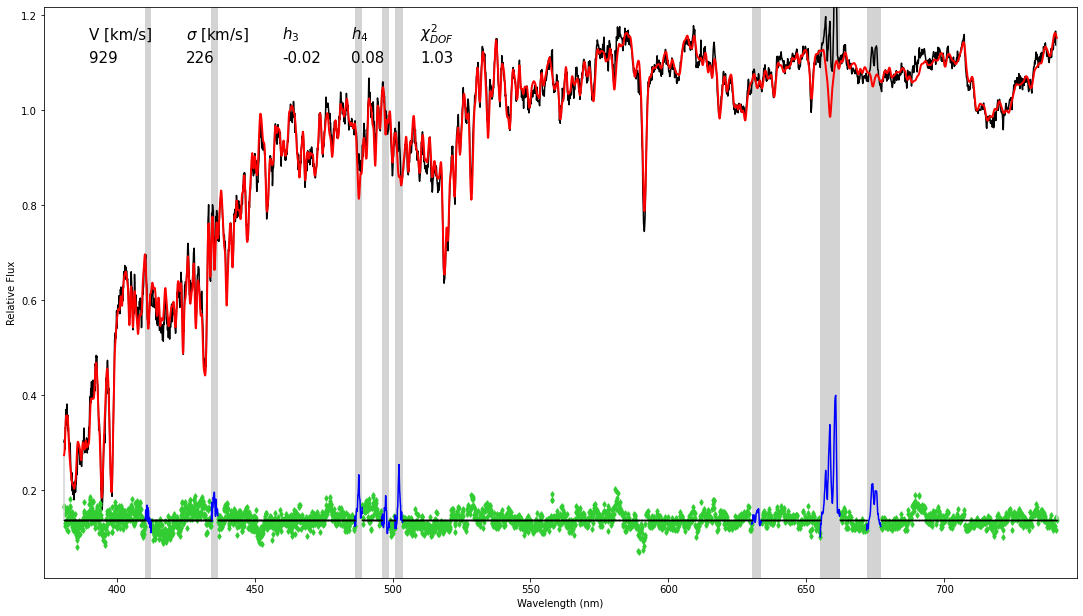

In [3]:
#Figure to show an adjust with 4 moments (v, sigma, h3, h4)


fig = plt.figure(figsize=(15,8))

pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, plot=True, moments=4,
          degree=12, vsyst=dv, clean=False, lam=lam_gal)


sols = pp.sol
#textx = 500
#texty = 1.1
textx = [390, 425, 460, 485, 510]
texty = 1.15
texty2 = 1.10
fs = 15
plt.text(textx[0], texty, r'V [km/s]', size=fs)
plt.text(textx[1], texty, r'$\sigma$ [km/s]', size=fs)
plt.text(textx[2], texty, r'$h_3$', size=fs)
plt.text(textx[3], texty, r'$h_4$', size=fs)
plt.text(textx[4], texty, r'$\chi^2_{DOF}$', size=fs)


plt.text(textx[0], texty2, str(int(sols[0])), size=fs)
plt.text(textx[1], texty2, str(int(sols[1])), size=fs)
plt.text(textx[2], texty2, "{:.2f}".format(sols[2]), size=fs)
plt.text(textx[3], texty2, "{:.2f}".format(sols[3]), size=fs)
plt.text(textx[4], texty2, "{:.2f}".format(pp.chi2), size=fs)


fig.set_size_inches(18.5, 10.5)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

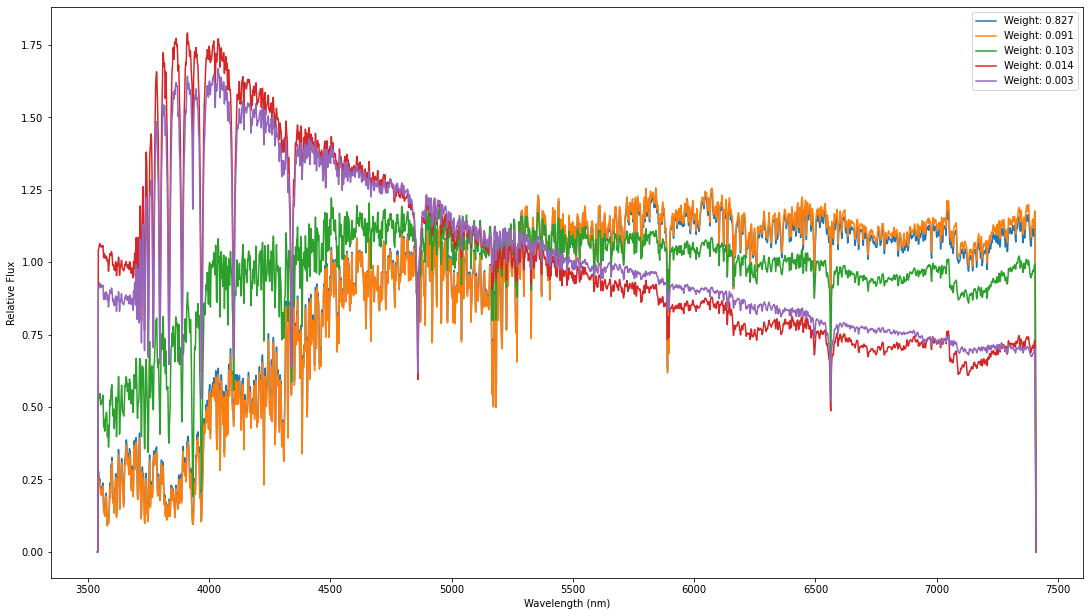

In [4]:
#Figure to show the templates used for fitting. Also plot the Weights.
#The templates ploted are NOTE Weighted yet.

fig = plt.figure(figsize=(15,8))

for i in range( len(pp.weights)):
    if pp.weights[i] != 0:
        
        plt.plot(np.exp(logLam_temp), pp.templates[:,i], label=r"Weight: %.3f"%pp.weights[i])
plt.xlabel(r"Wavelength (nm)")
plt.ylabel(r"Relative Flux")
plt.legend()
fig.set_size_inches(18.5, 10.5)
